<a href="https://colab.research.google.com/github/mingyu1021/AI-class/blob/main/10week/SimpleCNN_HumanActivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/AI-class/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/AI-class/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# ######################################
# ### ⭐ 데이터 스케일링 (StandardScaler) ###
# ######################################

scaler = StandardScaler()

# 3D -> 2D로 변형: (샘플, 타임스텝, 특성) -> (샘플 * 타임스텝, 특성)
n_samples_train, n_timesteps_train, n_features_train = trainX.shape
trainX_reshaped = trainX.reshape(-1, n_features_train)

# 훈련 데이터(trainX)로만 스케일러 학습(fit)
scaler.fit(trainX_reshaped)

# trainX 변환 및 3D 복원
trainX_scaled_reshaped = scaler.transform(trainX_reshaped)
trainX = trainX_scaled_reshaped.reshape(n_samples_train, n_timesteps_train, n_features_train)

# testX 변환 및 3D 복원
n_samples_test, n_timesteps_test, n_features_test = testX.shape
testX_reshaped = testX.reshape(-1, n_features_test)
testX_scaled_reshaped = scaler.transform(testX_reshaped)
testX = testX_scaled_reshaped.reshape(n_samples_test, n_timesteps_test, n_features_test)

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

print(X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape)

/tmp/ipython-input-3008172215.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3008172215.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3008172215.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3008172215.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6) (5881, 1) (1471, 1)


In [6]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D  # 필요한 레이어만 import
)
from tensorflow.keras.utils import to_categorical

## 1. 입력 레이어
# (128, 9) 형태의 단일 입력
main_input = Input(shape=(n_timesteps, n_features))

## 2. 첫 번째 Conv/Pool 블록
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(main_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)

## 3. 두 번째 Conv/Pool 블록 (성능 향상을 위해 한 층 더 추가)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

## 4. 분류기 (Classifier Head)
flat = Flatten()(pool2)
dense1 = Dense(100, activation='relu')(flat)
drop1 = Dropout(0.5)(dense1)  # 과적합 방지
outputs = Dense(n_outputs, activation='softmax')(drop1)

## 5. 모델 생성 및 컴파일
# 모델 이름을 simple_cnn_model로 변경
simple_cnn_model = Model(inputs=main_input, outputs=outputs)

simple_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
simple_cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       384,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,202 (1.57 MB)

 Trainable params: 411,202 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# --- Cell 4: 모델 훈련 ---
# 'cnn3_model'을 'lstm_model'로 변경
# 'model_history'를 'lstm_history'로 변경
simple_cnn_history = simple_cnn_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6278 - loss: 0.9436 - val_accuracy: 0.9457 - val_loss: 0.1358
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9373 - loss: 0.1669 - val_accuracy: 0.9474 - val_loss: 0.1159
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9472 - loss: 0.1348 - val_accuracy: 0.9525 - val_loss: 0.1120
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9549 - loss: 0.1158 - val_accuracy: 0.9559 - val_loss: 0.0964
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9518 - loss: 0.1187 - val_accuracy: 0.9542 - val_loss: 0.1027
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9548 - loss: 0.1040 - val_accuracy: 0.9508 - val_loss: 0.0891
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9549 - loss: 0.1063 - val_accuracy: 0.9474 - val_loss: 0.0899
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9555 - loss: 0.0969 - val_accuracy: 0

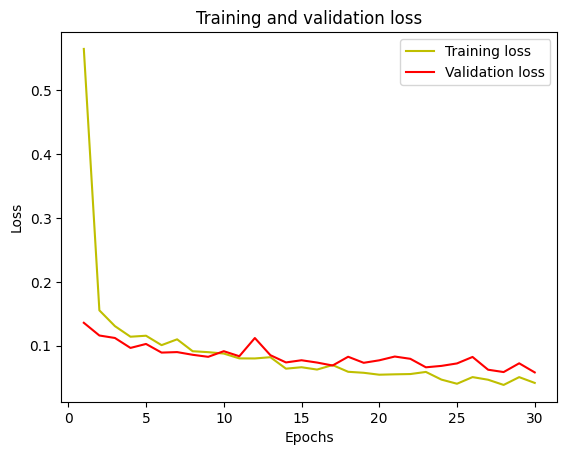

In [9]:
# --- Cell 5: 손실 시각화 ---
import matplotlib.pyplot as plt
import seaborn as sns

loss = simple_cnn_history.history['loss']
val_loss = simple_cnn_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

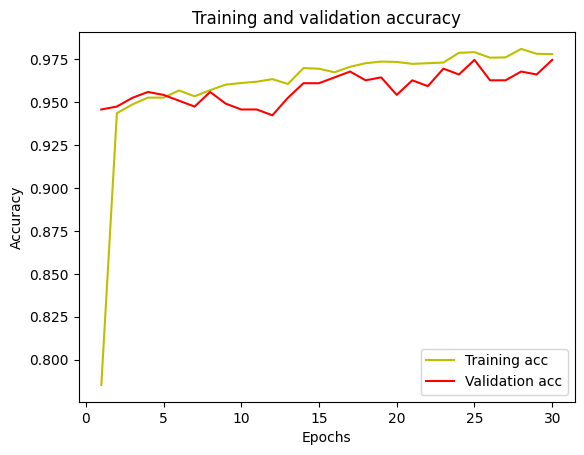

In [10]:
# --- Cell 6: 정확도 시각화 ---
# 'model_history'를 'lstm_history'로 변경
acc = simple_cnn_history.history['accuracy']
val_acc = simple_cnn_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[489   0   7   0   0   0]
 [  6 429  36   0   0   0]
 [  1   5 414   0   0   0]
 [  0   4   0 421  61   5]
 [  2   1   0  94 435   0]
 [  0   0   0   0   0 537]]
0.9246691550729556
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       496
           1       0.98      0.91      0.94       471
           2       0.91      0.99      0.94       420
           3       0.82      0.86      0.84       491
           4       0.88      0.82      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.92      2947
weighted avg       0.93      0.92      0.92      2947



<Axes: >

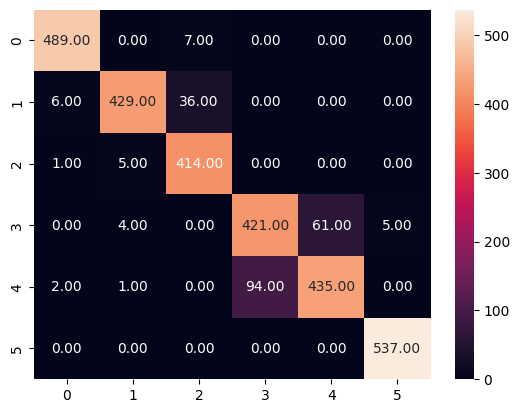

In [11]:
# --- Cell 7: 모델 평가 ---
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 'cnn3_model'을 'lstm_model'로 변경
pred = simple_cnn_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')